In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import pickle
from itertools import combinations, permutations
from collections import defaultdict
import matplotlib.pyplot as plt

# only allow 100 rows to display pandas
pd.set_option('display.max_rows', 100)

In [2]:
# import triad information
df_found = pd.read_csv('/Users/rweberla/Downloads/wholeNet_120U_triads.txt', names=['reciprocal1', 'reciprocal2','nid'])
df_found["reciprocal1"] = df_found["reciprocal1"].str.strip("[(")
df_found["reciprocal2"] = df_found["reciprocal2"].str.strip(")")
df_found["nid"] = df_found["nid"].str.strip("])")
df_found
df_found

,reciprocal1,reciprocal2,nid
0,720575940629970489,720575940627604977,720575940631267655
1,720575940629970489,720575940628049963,720575940620005542
2,720575940629970489,720575940627604977,720575940620005542
3,720575940629970489,720575940627604977,720575940626081319
4,720575940629970489,720575940615028143,720575940626081319
...,...,...,...
750728,720575940632454456,720575940644534820,720575940614817064
750729,720575940630682684,720575940621878125,720575940624821228
750730,720575940625674388,720575940621938017,720575940608967004
750731,720575940625674388,720575940621938017,720575940639258301


In [4]:
# Import neurons info
df_n = pd.read_csv('/Users/rweberla/Downloads/neurons.csv')
df_neurons = df_n[["root_id", "nt_type"]]
df_neurons

,root_id,nt_type
0,720575940596125868,ACH
1,720575940597856265,ACH
2,720575940597944841,ACH
3,720575940598267657,GABA
4,720575940599333574,ACH
...,...,...
139250,720575940661335681,GABA
139251,720575940661336193,ACH
139252,720575940661337217,ACH
139253,720575940661338497,NaN


In [5]:
# Convert reciprocal1 and reciprocal2 to integers
df_found['reciprocal1'] = df_found['reciprocal1'].astype(int)
df_found['reciprocal2'] = df_found['reciprocal2'].astype(int)

In [6]:
# Combine nid from df_neurons onto df_found_desc, reciprocal1 and reciprocal2
df_filtered1 = df_found.merge(df_neurons, left_on='reciprocal1', right_on='root_id', how="left",)
df_filtered2 = df_filtered1.merge(df_neurons, left_on='reciprocal2', right_on='root_id', how="left", suffixes=('_pre','_post'))
df_filtered2

,reciprocal1,reciprocal2,nid,root_id_pre,nt_type_pre,root_id_post,nt_type_post
0,720575940629970489,720575940627604977,720575940631267655,720575940629970489,GABA,720575940627604977,GLUT
1,720575940629970489,720575940628049963,720575940620005542,720575940629970489,GABA,720575940628049963,GABA
2,720575940629970489,720575940627604977,720575940620005542,720575940629970489,GABA,720575940627604977,GLUT
3,720575940629970489,720575940627604977,720575940626081319,720575940629970489,GABA,720575940627604977,GLUT
4,720575940629970489,720575940615028143,720575940626081319,720575940629970489,GABA,720575940615028143,ACH
...,...,...,...,...,...,...,...
750728,720575940632454456,720575940644534820,720575940614817064,720575940632454456,GABA,720575940644534820,GABA
750729,720575940630682684,720575940621878125,720575940624821228,720575940630682684,NaN,720575940621878125,ACH
750730,720575940625674388,720575940621938017,720575940608967004,720575940625674388,ACH,720575940621938017,NaN
750731,720575940625674388,720575940621938017,720575940639258301,720575940625674388,ACH,720575940621938017,NaN


In [7]:
# Find reciprocal1 and reciprocal2 edges that are ach, gaba
df_e_i_pairs = df_filtered2[((df_filtered2["nt_type_pre"] == "ACH") & (df_filtered2["nt_type_post"] == "GABA")|
                             (df_filtered2["nt_type_pre"] == "GABA") & (df_filtered2["nt_type_post"] == "ACH") |
                             (df_filtered2["nt_type_pre"] == "ACH") & (df_filtered2["nt_type_post"] == "GLUT")|
                             (df_filtered2["nt_type_pre"] == "GLUT") & (df_filtered2["nt_type_post"] == "ACH"))]
df_e_i_pairs = df_e_i_pairs[['reciprocal1', 'reciprocal2', 'nid', 'nt_type_pre', 'nt_type_post']] # These are triads with E/I pairs
df_e_i_pairs

,reciprocal1,reciprocal2,nid,nt_type_pre,nt_type_post
4,720575940629970489,720575940615028143,720575940626081319,GABA,ACH
6,720575940629970489,720575940615028143,720575940624508563,GABA,ACH
10,720575940629970489,720575940615028143,720575940623546603,GABA,ACH
13,720575940629970489,720575940613087218,720575940621570731,GABA,ACH
23,720575940629970489,720575940613087218,720575940626427529,GABA,ACH
...,...,...,...,...,...
750709,720575940636390263,720575940633691437,720575940614928827,GABA,ACH
750712,720575940640748659,720575940631526518,720575940639866275,ACH,GLUT
750722,720575940660151425,720575940631156781,720575940621112673,ACH,GLUT
750723,720575940660151425,720575940631156781,720575940618995028,ACH,GLUT


In [9]:
# Import classifications data
df_class = pd.read_csv('/Users/rweberla/Downloads/classification.csv')
df_class_f = df_class[['root_id', 'super_class']]
df_class_f

,root_id,super_class
0,720575940640144768,optic
1,720575940630759755,central
2,720575940637932009,central
3,720575940606131116,optic
4,720575940633723091,optic
...,...,...
139250,720575940632239661,sensory
139251,720575940624423312,optic
139252,720575940625090916,optic
139253,720575940631596103,optic


In [10]:
# Merge classifications data onto the "nid" column of df_e_i_pairs
df_e_i_pairs['nid'] = df_e_i_pairs['nid'].astype(int)
df_class_all = df_e_i_pairs.merge(df_class_f, left_on='nid', right_on='root_id', how="left")
df_class_all

,reciprocal1,reciprocal2,nid,nt_type_pre,nt_type_post,root_id,super_class
0,720575940629970489,720575940615028143,720575940626081319,GABA,ACH,720575940626081319,central
1,720575940629970489,720575940615028143,720575940624508563,GABA,ACH,720575940624508563,central
2,720575940629970489,720575940615028143,720575940623546603,GABA,ACH,720575940623546603,central
3,720575940629970489,720575940613087218,720575940621570731,GABA,ACH,720575940621570731,central
4,720575940629970489,720575940613087218,720575940626427529,GABA,ACH,720575940626427529,central
...,...,...,...,...,...,...,...
377283,720575940636390263,720575940633691437,720575940614928827,GABA,ACH,720575940614928827,optic
377284,720575940640748659,720575940631526518,720575940639866275,ACH,GLUT,720575940639866275,optic
377285,720575940660151425,720575940631156781,720575940621112673,ACH,GLUT,720575940621112673,optic
377286,720575940660151425,720575940631156781,720575940618995028,ACH,GLUT,720575940618995028,optic


In [11]:
# Find the percentage counts for each unique super class 
df_class_all['super_class'].value_counts(normalize=True)*100

super_class
central               52.323689
optic                 29.724773
visual_projection      9.386463
descending             6.624382
visual_centrifugal     0.820328
motor                  0.721465
ascending              0.207534
sensory                0.136766
endocrine              0.054600
Name: proportion, dtype: float64

In [12]:
# Filter down to descending neurons in the third position (super class)
df_descending = df_class_all[df_class_all['super_class'] == 'descending']
df_descending

,reciprocal1,reciprocal2,nid,nt_type_pre,nt_type_post,root_id,super_class
93,720575940631267655,720575940608545219,720575940610505006,ACH,GABA,720575940610505006,descending
124,720575940605876866,720575940624296328,720575940631520312,GABA,ACH,720575940631520312,descending
125,720575940605876866,720575940643940900,720575940631520312,GABA,ACH,720575940631520312,descending
1039,720575940619895125,720575940614113682,720575940644494752,ACH,GLUT,720575940644494752,descending
1074,720575940619895125,720575940614113682,720575940628352850,ACH,GLUT,720575940628352850,descending
...,...,...,...,...,...,...,...
373599,720575940629004158,720575940641229520,720575940628225167,ACH,GABA,720575940628225167,descending
374246,720575940613142191,720575940624576806,720575940607761244,ACH,GABA,720575940607761244,descending
374247,720575940613142191,720575940624576806,720575940629139968,ACH,GABA,720575940629139968,descending
376292,720575940641229520,720575940614336739,720575940628225167,GABA,ACH,720575940628225167,descending


In [13]:
# Find the unique third position root_ids that are descending
unique_desc = df_descending['nid'].drop_duplicates()
unique_desc

93        720575940610505006
124       720575940631520312
1039      720575940644494752
1074      720575940628352850
1188      720575940611644529
                 ...        
360678    720575940628467830
360680    720575940615898730
360681    720575940636606554
360682    720575940639705077
376806    720575940638664355
Name: nid, Length: 829, dtype: int64

In [14]:
# Total unique descending neurons in the flybrain
total_desc = df_class_f[df_class_f['super_class'] == 'descending']
total_desc

,root_id,super_class
5,720575940632934751,descending
60,720575940640128720,descending
461,720575940610010521,descending
557,720575940615495867,descending
716,720575940631498563,descending
...,...,...
138269,720575940605041330,descending
138514,720575940623128269,descending
138844,720575940618870881,descending
139040,720575940609260494,descending


In [15]:
# Percentage of Dns in traid
len(unique_desc)/len(total_desc)*100

63.62240982348427

In [16]:
# Percentage of DNs in brain
len(total_desc)/len(df_class_f)*100

0.9356935119026247

In [18]:
# Percentage of each super class in the brain
df_class_f['super_class'].value_counts(normalize=True)*100

super_class
optic                 55.679150
central               23.258052
sensory               12.138164
visual_projection      5.782916
ascending              1.696169
descending             0.935694
visual_centrifugal     0.376288
motor                  0.076119
endocrine              0.057449
Name: proportion, dtype: float64

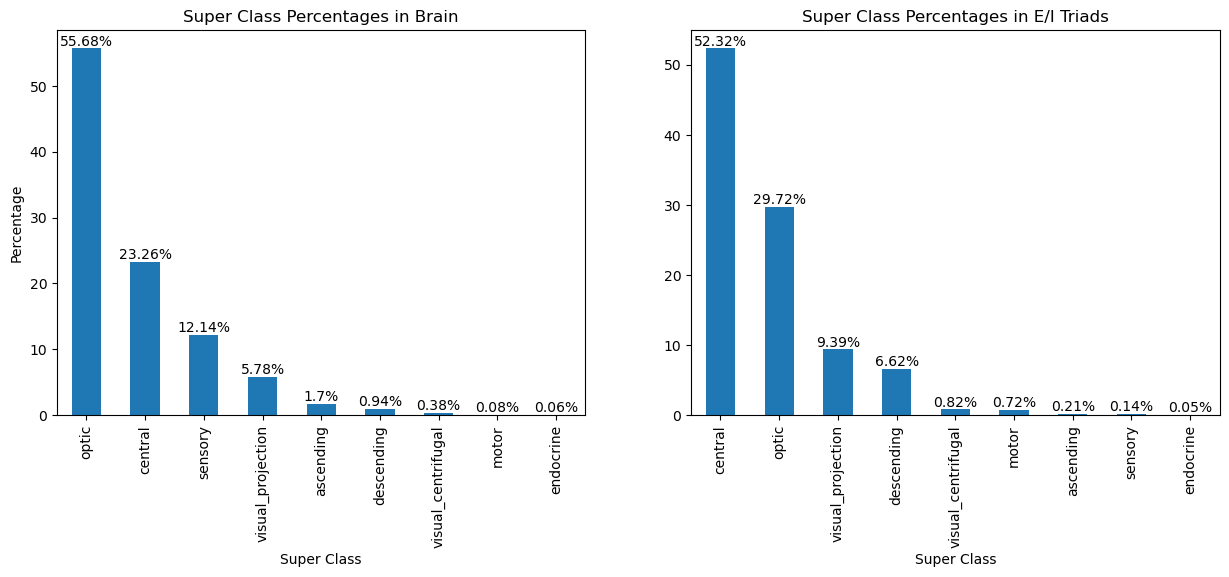

In [34]:
# plot the percentage of each super class in the brain as well as the unique third position super class percentages (with E/I pairs)
# As two pie charts
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
(df_class_f['super_class'].value_counts(normalize=True)*100).plot.bar(ax=ax[0])
# Add in labels for each bar
for i in ax[0].patches:
    ax[0].text(i.get_x() + i.get_width() / 2, i.get_height(), str(round(i.get_height(), 2)) + '%', ha='center', va='bottom')
ax[0].set_title('Super Class Percentages in Brain')
ax[0].set_ylabel('Percentage')
ax[0].set_xlabel('Super Class')
(df_class_all['super_class'].value_counts(normalize=True)*100).plot.bar(ax=ax[1])
# Add in labels for each bar
for i in ax[1].patches:
    ax[1].text(i.get_x() + i.get_width() / 2, i.get_height(), str(round(i.get_height(), 2)) + '%', ha='center', va='bottom')
ax[1].set_title('Super Class Percentages in E/I Triads')
ax[1].set_xlabel('Super Class')
plt.show()
